In [1]:
from data_science_tools_for_pendigits_rough_paths import *
import iisignature
from itertools import combinations
import networkx as nx
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)

In [406]:
def signature(path, depth):
    width = path.shape[1]
    length = path.shape[0]
    if length <= 1:
        return np.array([0.]*(tosig.sigdim(width, depth)-1))
    else:
        return iisignature.sig(path, depth)

def p_variation_path(p, path, depth, norm='l1'):
    """return rough p-variation"""
    assert norm in ['l1', 'l2']
    length = path.shape[0]
    if norm=='l1':
        sig_n = lambda sig: np.sum([np.abs(x) for x in sig])
    elif norm=='l2':
        sig_n = lambda sig: np.sum([x*x for x in sig])
    dist = lambda a,b: sig_n(signature(path[a:b+1,:],depth)[1:])
    pv = p_var_backbone(length, p, dist)
    return pv.value

def sig_norm(sig1, sig2, norm='l1'):
    assert norm in ['l1', 'l2']
    if norm == 'l1':
        return np.sum([np.abs(x) for x in (sig1-sig2)])
    elif norm == 'l2':
        return np.sum([x*x for x in (sig1-sig2)])

def p_variation_distance(path1, path2, p, depth, width=2, norm='l1'):
    """path1 and path2 must be numpy arrays of equal lenght
       return the rough p-variation distance"""
    
    assert norm in ['l1', 'l2']
    assert path1.shape[0] == path2.shape[0]
    assert path1.shape[1] == path2.shape[1]
    
    length = path1.shape[0]

    dist = lambda a,b: sig_norm(signature(path1[a:b+1,:], depth),
                                signature(path2[a:b+1,:], depth), 
                                norm)
    
    # use Terry algo with complexity O(NlogN) instead of O(N^2)
    pv = p_var_backbone(length, p, dist)
#     pv_ref = p_var_backbone_ref(len(dyad_path1), p, dist)
#     pv_err = abs(pv.value - pv_ref) + p_var_points_check(pv, p, dist)
#     print(pv.value, pv_ref, pv_err)
    
    return pv.value

# Example

In [414]:
def generate_data(alpha=5., N=100):
    
    mu = np.random.normal(loc=0, scale=1, size=1)[0]
    a = np.random.randint(16, 32)/N
    b = np.random.randint(32, 96)/N

    X = []
    for k in range(N):
        if (k/N<a)|(k/N>b):
            X.append(0.)
        else:
            X.append(alpha)
    X = np.array(X)

    C = np.array([(6.+mu)*x/alpha+np.random.normal(loc=0, scale=1, size=1)[0] for x in X])
    B = np.array([(6.+mu)*X[k]*(k/N-a)*(b-a)+np.random.normal(loc=0, scale=1, size=1)[0] for k in range(len(X))])
    F = np.array([(6.+mu)*X[k]*(b-a)*(b-k/N)+np.random.normal(loc=0, scale=1, size=1)[0] for k in range(len(X))])
    
    return C,B,F

## What does the data look like?

In [416]:
C,B,F = generate_data()

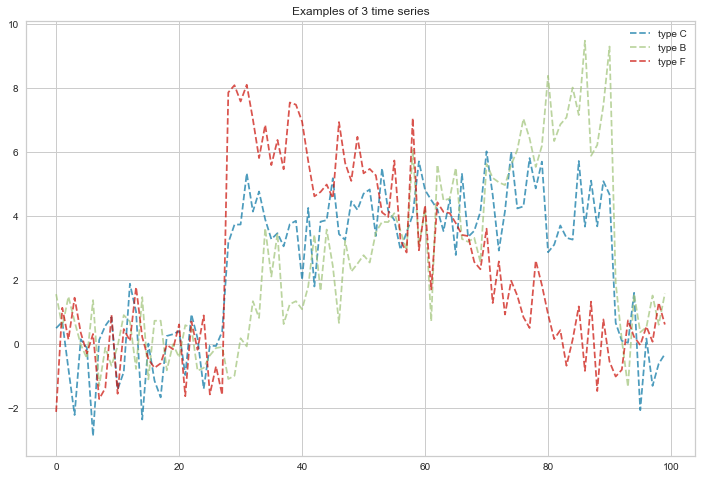

In [431]:
pd.DataFrame([C,B,F], index=['type C', 'type B', 'type F']).T.plot(title='Examples of 3 time series', alpha=0.7, ls='--')
plt.show()

In [442]:
def run_experiment(sig_lab=True, p_var=2, N=128, depth=2, norm_const=3, norm='l1', nb_runs=100):

    # here we store predictions and true answers
    predictions = []
    true_labels = []

    # run nb_runs experiments
    for i in range(nb_runs):
        
        # here we store the computed sequences and labels
        sequences = []
        labels = []
        
        # generate 3 time series of each class
        for j in range(3):
            C,B,F = generate_data(alpha=20., N=N)
            sequences.append(C)
            sequences.append(B)
            sequences.append(F)
            labels.append('C')
            labels.append('B')
            labels.append('F')
        
        # generate a random time series of one of the 3 classes
        ind = np.random.randint(3)
        if ind==0:
            x,_,_ = generate_data(alpha=20., N=N)
            target = 'C'
        elif ind==1:
            _,x,_ = generate_data(alpha=20., N=N)
            target = 'B'
        else:
            _,_,x = generate_data(alpha=20., N=N)
            target = 'F'
        
        # using signatures
        if sig_lab:
            time_transformer = AddTime()
            sequences = time_transformer.fit_transform([s*norm_const for s in sequences])
            time_transformer = AddTime()
            x = time_transformer.fit_transform([norm_const*x])[0]
            
            # distances computed using global signature similarity measure
            distances = [sig_norm(signature(x, depth), signature(s, depth), norm) for s in sequences]
            
            # distances computed using p-variations rough distance
#             distances = [p_variation_distance(x, s, p=p_var, depth=depth, norm=norm) for s in sequences]
        
        # using FastDTW
        else:
            distances = [fastdtw(x, s, dist=euclidean)[0] for s in sequences]

        # select 1-nearest neighbour
        predicted_label = labels[np.argmin(distances)]
        
        # predictions and true labels
        predictions.append(predicted_label)
        true_labels.append(target)
        
    return 100.*accuracy_score(true_labels, predictions)

# Classification with (fast)DTW

In [570]:
N = 200
t = time.time()
fastDTW_score = run_experiment(sig_lab=False, p_var=2, N=N, depth=2, norm_const=3, norm='l1', nb_runs=100)
print('accuracy with DTW: {:.3f} % -- time taken: {:.1f} s for N = {}'.format(fastDTW_score, time.time()-t, N))

accuracy with DTW: 78.000 % -- time taken: 66.9 s for N = 200


# Classification with global p-variation distance

This assumes that all time series have same length

2
3
4
5
6
7


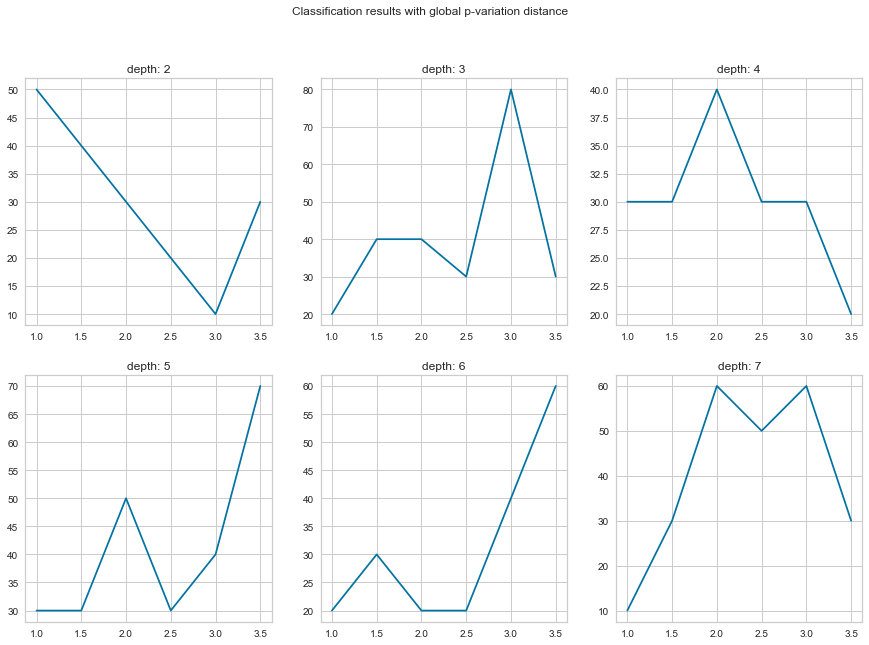

In [407]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
i=0
j=-1
for depth in [2, 3, 4, 5, 6, 7]:
    print(depth)
    accuracies = []
    j+=1
    kj=j%3
    if (kj==0)&(j>0):
        i+=1
    for p_var in np.arange(1, 4, 0.5):
        accuracies.append(run_experiment(sig_lab=True, norm_const=1, depth=depth, norm='l1', p_var=p_var, N=128))
    axes[i,kj].plot(np.arange(1, 4, 0.5), accuracies)
    axes[i,kj].set_title('depth: {}'.format(depth))
fig.suptitle('Classification results with global p-variation distance')
plt.show()

# Classification with Signatue distance

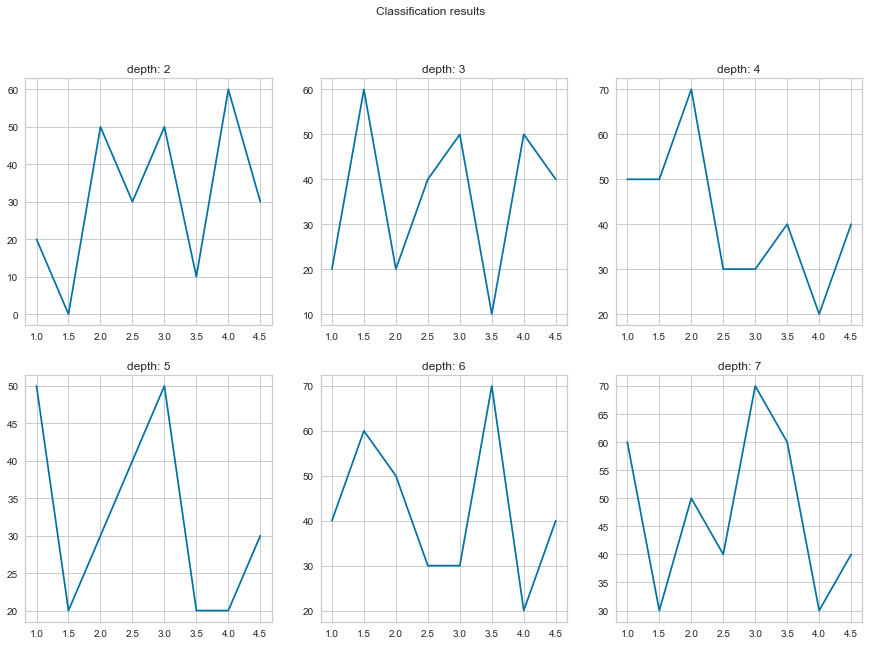

In [353]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
i=0
j=-1
for depth in [2, 3, 4, 5, 6, 7]:
    accuracies = []
    j+=1
    kj=j%3
    if (kj==0)&(j>0):
        i+=1
    for norm_const in np.arange(1, 5, 0.5):
        accuracies.append(run_experiment(sig_lab=True, norm_const=norm_const, depth=depth, norm='l1', p_var=2, N=128))
    axes[i,kj].plot(np.arange(1, 5, 0.5), accuracies)
    axes[i,kj].set_title('depth: {}'.format(depth))
fig.suptitle('Classification results')
plt.show()

# GeometricDTW (our idea)

In [591]:
def rolling_window(paths, depth=2, window_size=5, transform=True):

    lower_bound = int(window_size/2)
    upper_bound = int(np.ceil(window_size/2))
    
    pathlets=[]
    
    for path in paths:
        
        pathlet=[]
        
        l=len(path)
        
        for k in range(l):
            if k-lower_bound<0:
                lb=k
                ub=upper_bound+k
            elif k+upper_bound>l:
                ub=l-1
            else:
                lb=lower_bound
                ub=upper_bound
            
            if transform:
                time_transformer = AddTime()
                pathlet.append(signature(time_transformer.fit_transform([path[k-lb:k+ub]])[0], depth))
            else:
                pathlet.append(signature(path[k-lb:k+ub], depth))
            
        pathlets.append(np.array(pathlet))
    
    
    return pathlets

In [572]:
def geomDTW(N=128, window_size=5, depth=2, norm_const=3, nb_runs=100, transform=True):

    # here we store predictions and true answers
    predictions = []
    true_labels = []

    # run nb_runs experiments
    for i in range(nb_runs):
        
        # here we store the computed sequences and labels
        sequences = []
        labels = []
        
        # generate 3 time series of each class
        for j in range(3):
            C,B,F = generate_data(alpha=20., N=N)
            sequences.append(C*norm_const)
            sequences.append(B*norm_const)
            sequences.append(F*norm_const)
            labels.append('C')
            labels.append('B')
            labels.append('F')
        
        # generate a random time series of one of the 3 classes
        ind = np.random.randint(3)
        if ind==0:
            x,_,_ = generate_data(alpha=20., N=N)
            target = 'C'
        elif ind==1:
            _,x,_ = generate_data(alpha=20., N=N)
            target = 'B'
        else:
            _,_,x = generate_data(alpha=20., N=N)
            target = 'F'
        
        # signature transform
        sequences_sig = rolling_window(sequences, depth=depth, window_size=window_size, transform=transform)
        x_sig = rolling_window([x*norm_const], depth=depth, window_size=window_size, transform=transform)[0]
        
        # GeomDTW
        distances = [fastdtw(x_sig, s, dist=euclidean)[0] for s in sequences_sig]

        # select 1-nearest neighbour
        predicted_label = labels[np.argmin(distances)]
        
        # predictions and true labels
        predictions.append(predicted_label)
        true_labels.append(target)
        
    return 100.*accuracy_score(true_labels, predictions)

In [573]:
for depth in [2, 3, 4, 5]:
    for window_size in [5, 10, 15, 20]:
        t = time.time()
        acc = geomDTW(N=200, window_size=window_size, depth=depth, norm_const=1, nb_runs=100)
        print('depth: {} -- roll window: {} -- accuracy: {:.1f} % -- time taken: {:.2f} s'.format(depth, window_size, acc, time.time()-t))

depth: 2 -- roll window: 5 -- accuracy: 67.0 % -- time taken: 62.81 s
depth: 2 -- roll window: 10 -- accuracy: 72.0 % -- time taken: 63.90 s
depth: 2 -- roll window: 15 -- accuracy: 77.0 % -- time taken: 63.45 s
depth: 2 -- roll window: 20 -- accuracy: 70.0 % -- time taken: 63.80 s
depth: 3 -- roll window: 5 -- accuracy: 59.0 % -- time taken: 100.65 s
depth: 3 -- roll window: 10 -- accuracy: 71.0 % -- time taken: 77.41 s
depth: 3 -- roll window: 15 -- accuracy: 78.0 % -- time taken: 88.89 s
depth: 3 -- roll window: 20 -- accuracy: 70.0 % -- time taken: 77.28 s
depth: 4 -- roll window: 5 -- accuracy: 68.0 % -- time taken: 64.83 s
depth: 4 -- roll window: 10 -- accuracy: 64.0 % -- time taken: 66.44 s
depth: 4 -- roll window: 15 -- accuracy: 68.0 % -- time taken: 67.05 s
depth: 4 -- roll window: 20 -- accuracy: 67.0 % -- time taken: 73.67 s
depth: 5 -- roll window: 5 -- accuracy: 61.0 % -- time taken: 70.60 s
depth: 5 -- roll window: 10 -- accuracy: 71.0 % -- time taken: 73.96 s
depth: 5 

In [566]:
a,b,_ = generate_data(alpha=8., N=128)
pathlets = rolling_window([a, b], depth=3, window_size=10, transform=False)

In [567]:
d, p = fastdtw(pathlets[0], pathlets[1], dist=euclidean)

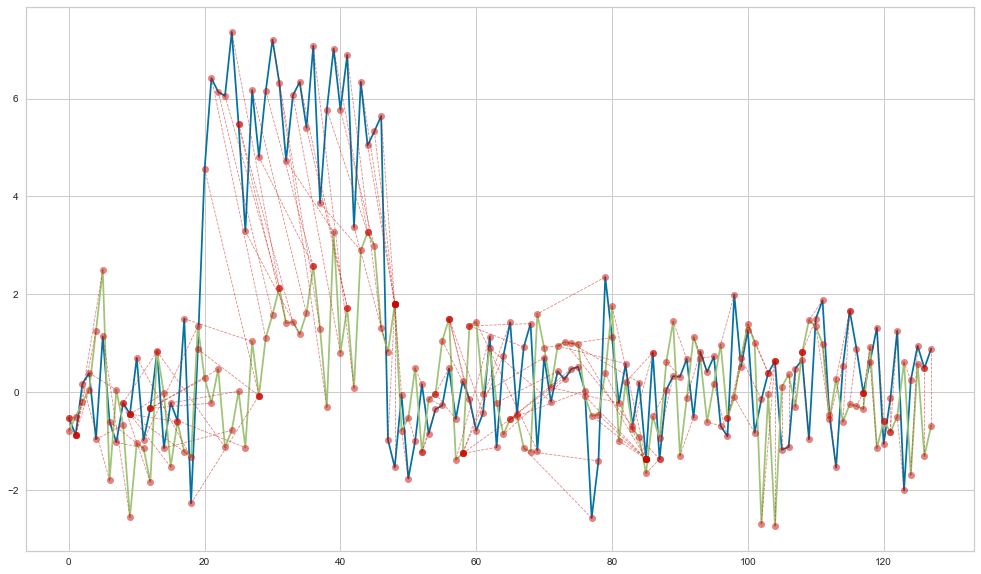

In [568]:
fig, ax = plt.subplots(figsize=(17, 10))
plt.plot(a)
plt.plot(b)
for node in p:
    x1=a[node[0]]
    x2=b[node[1]]
    plt.plot([node[0], node[1]], [x1, x2], 'r--', marker='o', alpha=0.5, linewidth=0.8)
plt.show()

In [630]:
depth=3
window_size=15
transform_flag='pen'
scale_factor=1.

xx_train, yy_train = random_subsample(size=5, replace=False, transform_flag=transform_flag)
xx_train = [x*scale_factor for x in xx_train]
xx_train = rolling_window(xx_train, depth=depth, window_size=window_size, transform=False)

_,_,xx_test,yy_test = which_transform(transform_flag)
xx_test = rolling_window([x*scale_factor for x in xx_test[:1000]], depth=depth, window_size=window_size, transform=False)
# xx_test = xx_test[:1000]
yy_test = yy_test[:1000]

k_nns=[]
predictions=[]
running_score=[]

num=1
print_every_n_instances=1000

for x_test, y_test in zip(xx_test, yy_test):

    # start_finding neighbors
    distances = []
    labels = []
    for x_train, y_train in zip(xx_train, yy_train):
        d, _ = fastdtw(x_test, x_train, dist=euclidean)
        distances.append(d)
        labels.append(y_train)
    predictions.append(labels[np.argmin(distances)])

    # partial score per instances tested so far
    partial_score = accuracy_score(y_true=yy_test[:num], y_pred=predictions)
    running_score.append(partial_score)
    
    # print progress
    if num%print_every_n_instances==0:
        print('tested {}/{} --- partial_score: {:.2f} %'.format(num, len(xx_test), partial_score*100.))
    num+=1

tested 1000/1000 --- partial_score: 79.90 %


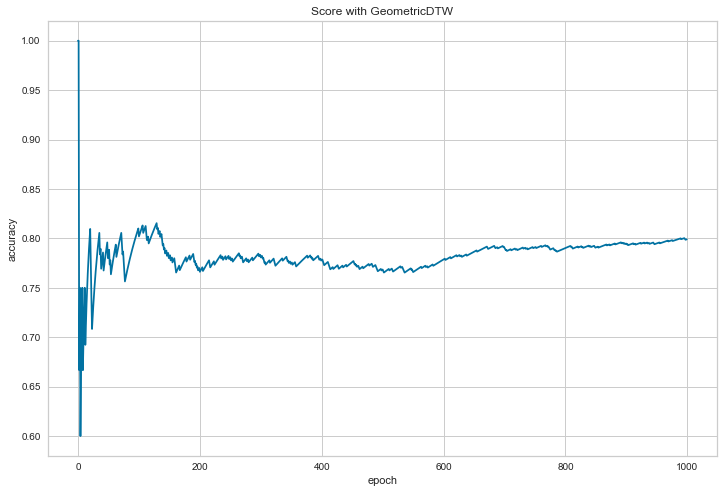

In [631]:
plt.plot(running_score)
plt.title('Score with GeometricDTW')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

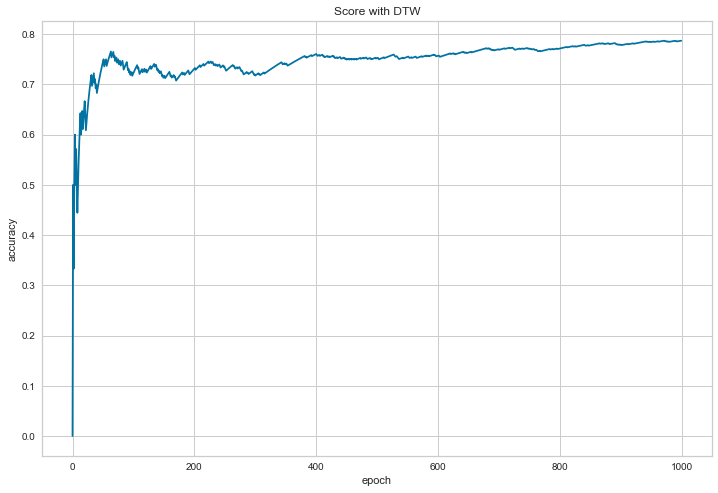

In [626]:
plt.plot(running_score)
plt.title('Score with DTW')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## p-variation distance between differently sampled paths

Let $X=(X_1,...,X_M)$ and $Y=(Y_1,...,Y_N)$ be two discrete paths parametrized over the intervals $I=[I_{-},I_{+}]$ and $J=[J_{-},J_{+}]$ respectively. Consider the maximal proper index sets 

$$D_I=\{I_{-}=i_0<i_1<...<i_M=I_{+}\}$$ 

and 

$$D_J=\{J_{-}=j_0<j_1<...<j_N=J_{+}\}$$

of $X$ and $Y$ respectively. Let 

$$R=max(M, N)$$

$$K_{-}=min(I_{-},J_{-})$$

$$K_{+}=max(I_{+},J_{+})$$

Define:

$$D_K = \{K_{-}=k_0<k_1<...<k_R=K_{+}\}$$

$$\alpha: D_K \rightarrow D_I$$

$$\beta: D_K \rightarrow D_J$$

where $\alpha$ and $\beta$ are two increasing surjections.

We can now define the warping p-variation signature distance:

$$d^{warp-pvar}(X, Y) = \inf_{\alpha, \beta}\{p_{var}(X, Y, [K_{-},K_{+}])\} $$

$$= \inf_{\alpha, \beta}\{(\sup_{D_K}\sum_{t_k \in D_K}||S(X)_{\alpha(t_{k-1}), \alpha(t_k)} - S(Y)_{\beta(t_{k-1}), \beta(t_k)}||^p)^{\frac{1}{p}}\}$$

$$= \inf_{\alpha, \beta}\{(\sup_{D_K}\sum_{t_k \in D_K}||S(X \circ \alpha)_{t_{k-1}, t_k} - S(Y \circ \beta)_{t_{k-1}, t_k}||^p)^{\frac{1}{p}}\}$$

In [6]:
def generate_network(long_dim, short_dim):
    
    G = nx.grid_graph(dim=[short_dim, long_dim])

    layout = {}
    for a,b in nx.spring_layout(G).keys():
        layout[(a,b)] = np.array([int(a),int(b)])

    G = G.to_directed()

    for i in range(long_dim):
        if i == 0:
            for j in range(1, short_dim):
                G.remove_edge((i,j), (i,j-1))
        else:
            for j in range(short_dim):
                if j == 0:
                    G.remove_edge((i,j), (i-1,j))
                else:
                    G.remove_edge((i,j), (i-1,j))
                    G.remove_edge((i,j), (i,j-1))

    for i in range(long_dim):
        for j in range(short_dim):
            for k_i in range(i, long_dim):
                for k_j in range(j, short_dim):
                    G.add_edge((i,j), (k_i,k_j))
                    
    return G, layout

In [7]:
def prepare_lattice_paths(G, long_dim, short_dim, cutoff=None):
    lattice_paths = []
    for path in nx.all_simple_paths(G, source=(0,0), target=(long_dim-1, short_dim-1), cutoff=cutoff):
        lattice_paths.append(path)
    return [lattice_paths[k] for k in np.array([len(d) for d in lattice_paths]).argsort()]

In [59]:
def sub_lattice_paths(lattice_path):
    sub_paths = []
    for k in range(1, len(lattice_path)-1):
        index_list = list(range(k)) + list(range(k+1,len(lattice_path)))
        sub_paths.append([lattice_path[j] for j in index_list])
    return sub_paths

In [66]:
def align_paths(longer_path, shorter_path, lattice_path):
    p1 = np.array([longer_path[k] for k in [j[0] for j in lattice_path]])
    p2 = np.array([shorter_path[k] for k in [j[1] for j in lattice_path]])
    return p1, p2

In [10]:
def brute_force_warped_pvariation(longer_path, shorter_path, ordered_lattice_paths, p_var, depth, norm):
    t = time.time()
    long_dim = longer_path.shape[0]
    short_dim = shorter_path.shape[0]
    warped_p_variations = []
    all_p_variations = {}
    for lattice_path in ordered_lattice_paths:
        longer_aligned, shorter_aligned = align_paths(longer_path, shorter_path, lattice_path)
        warped_p_variations.append(p_variation_distance(longer_aligned, shorter_aligned, p_var, depth, norm))
        all_p_variations[tuple(lattice_path)] = warped_p_variations[-1]
    warped_pvar = np.min(warped_p_variations)
    min_surjection = ordered_lattice_paths[np.argmin(warped_p_variations)]
    return warped_pvar, min_surjection, all_p_variations

In [51]:
def sig_pairwise_distance(node1, node2, longer_path, shorter_path, depth, norm):
    """given a node pair (node1, node2), returns the signature distance between the sub-pathlets defined by the 2 nodes"""
    # memoization
    if (node1, node2) in signature_pairwise_distances.keys():
        return signature_pairwise_distances[(node1, node2)]
    dist = sig_norm(tosig.stream2sig(longer_path[node1[0]:node2[0]+1], depth), 
                    tosig.stream2sig(shorter_path[node1[1]:node2[1]+1], depth), 
                    norm)
    signature_pairwise_distances[(node1, node2)] = copy.deepcopy(dist)
    return dist

def partition_sum_warp(partition, longer_path, shorter_path, p_var, depth, norm, optimize):
    """given an interval partition D, returns sum_D{||S(p1)_k,k+1 - S(p2)_k,k+1||}"""
    node_index = 0
    maximum_warping_intervals = len(partition)-1
    partition_sum = sig_pairwise_distance(partition[node_index], partition[node_index+1], longer_path, shorter_path, depth, norm)**p_var
    if (optimize) & (not is_empty(global_minimum)): # Branch-and-Bound
                
#         while partition_sum < local_minima[node_index+1]**p_var:
#             if node_index == maximum_warping_intervals-2:

        while partition_sum < global_minimum['GM']**p_var:
            if node_index == maximum_warping_intervals-2:
                partition_sum += sig_pairwise_distance(partition[node_index], partition[node_index+1], longer_path, shorter_path, depth, norm)**p_var
                return partition_sum**(1./p_var)
            node_index += 1
            node1, node2 = partition[node_index], partition[node_index+1]
            partition_sum += sig_pairwise_distance(node1, node2, longer_path, shorter_path, depth, norm)**p_var
    else:
        for node_index in range(1, maximum_warping_intervals):
            partition_sum += sig_pairwise_distance(partition[node_index], partition[node_index+1], longer_path, shorter_path, depth, norm)**p_var
        return partition_sum**(1./p_var)     
        
def p_variation_lattice_path(lattice_path, longer_path, shorter_path, p_var, depth, norm, optimize):
    """given a lattice path (i.e. a warping alignement), returns the p-variation distance between the sub-pathlets 
       defined by the projections of the lattice path onto the axis of the graph, with maximal partition length
       given by the number of nodes in the lattice path"""
    if tuple(lattice_path) in p_variations:
        return p_variations[tuple(lattice_path)]
    vv = partition_sum_warp(lattice_path, longer_path, shorter_path, p_var, depth, norm, optimize)
    values = []
    if vv:
        values.append(vv)
        retained_path[tuple(lattice_path)] = True
        
    # Dynamic programming (recursion) step
    for sub_lattice_path in sub_lattice_paths(lattice_path):
        values.append(p_variations[tuple(sub_lattice_path)])
    p_var_value = np.max(values)
    p_variations[tuple(lattice_path)] = copy.deepcopy(p_var_value)
    
#     if optimize:
#         ind = len(lattice_path)-1
#         if ind not in local_minima:
#                 local_minima[ind] = p_var_value
#         else:
#             if p_var_value < local_minima[ind]:
#                 local_minima[ind] = p_var_value     
                
    return p_var_value

def final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm, optimize=False):
    """given all non-decreasing warpings made of k partition intervals, recursively calculates the warped p-variation 
       distance defined by alignements formed by k+1 partition intervals.
       Returns the minimum over all possible non-decreasing alignements."""
    for lat_path in ordered_lattice_paths[1:]:
        p_var_val = p_variation_lattice_path(lat_path, longer_path, shorter_path, p_var, depth, norm, optimize)
        # initialization
        if not global_minimum:
            global_minimum['GM'] = copy.deepcopy(p_var_val)
            best_path = lat_path
        # recursion
        if p_var_val < global_minimum['GM']:
            global_minimum['GM'] = copy.deepcopy(p_var_val)
            best_path = lat_path
    return global_minimum['GM'], best_path

# A first attempt

In [270]:
p_var = 2
depth = 2
norm = 'l2'
width = 2

# dimensions of time series
long_dim = 100
short_dim = 5

In [276]:
longer_path = np.array([x for x in np.cumsum(np.random.randn(long_dim-1, 1))] + 
                       [s for s in np.random.normal(loc=1,scale=10,size=3)])

shorter_path = np.array([s for s in np.random.normal(loc=1,scale=3,size=short_dim-4)]+
                        [x for x in np.cumsum(np.random.randn(4, 1))])

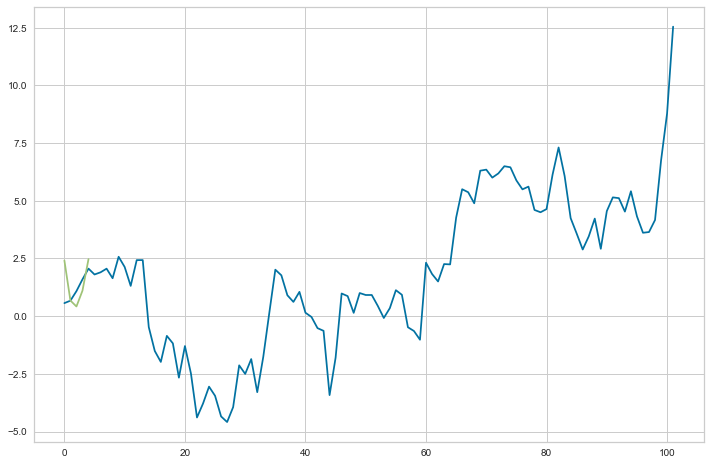

In [277]:
plt.plot(longer_path)
plt.plot(shorter_path)
plt.show()

In [278]:
time_transformer = AddTime()
longer_path = time_transformer.fit_transform([longer_path])[0]
shorter_path = time_transformer.fit_transform([shorter_path])[0]

In [56]:
G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim, cutoff=3)

In [57]:
# initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
# signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
# p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
# global_minimum = {}
# t1 = time.time()
# p_v, l_p = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)
# t2 = time.time()
# print(t2-t1)
# print(l_p)
# print(p_v)

In [58]:
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {}
# local_minima = {1:initialization_value}
retained_path = {}
t3 = time.time()
p_v_opt, l_p_opt = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm, optimize=True)
t4 = time.time()
print(t4-t3)
print(l_p_opt)
print(p_v_opt)

using precalculated signatures between (0, 0) and (1, 2)
using precalculated signatures between (0, 0) and (3, 3)
using precalculated signatures between (0, 0) and (2, 1)
using precalculated signatures between (0, 0) and (3, 2)
using precalculated signatures between (0, 0) and (1, 1)
using precalculated signatures between (0, 0) and (0, 1)
using precalculated signatures between (0, 0) and (3, 1)
using precalculated signatures between (0, 0) and (2, 2)
using precalculated signatures between (0, 0) and (2, 3)
using precalculated signatures between (0, 0) and (0, 2)
using precalculated signatures between (0, 0) and (3, 0)
using precalculated signatures between (0, 0) and (2, 4)
using precalculated signatures between (0, 0) and (0, 4)
using precalculated signatures between (0, 0) and (2, 0)
using precalculated signatures between (0, 0) and (3, 4)
using precalculated signatures between (0, 0) and (0, 3)
using precalculated signatures between (0, 0) and (1, 3)
using precalculated signatures 

In [49]:
signature_pairwise_distances

{((0, 0), (5, 4)): 28.972156446156706,
 ((0, 0), (1, 0)): 0.04974657300558698,
 ((1, 0), (5, 4)): 25.972031977405944,
 ((0, 0), (4, 0)): 18008.689265949848,
 ((0, 0), (1, 2)): 339.97213993065384,
 ((0, 0), (3, 3)): 174.49832939977915,
 ((0, 0), (2, 1)): 210.9224648930245,
 ((0, 0), (3, 2)): 302.21561309537674,
 ((0, 0), (1, 1)): 225.5630286570638,
 ((0, 0), (0, 1)): 224.7055229469068,
 ((0, 0), (3, 1)): 198.96745335841078,
 ((0, 0), (2, 2)): 322.47521231776295,
 ((0, 0), (2, 3)): 183.0652417246716,
 ((0, 0), (0, 2)): 339.1044796581716,
 ((0, 0), (3, 0)): 10.441465468245827,
 ((0, 0), (2, 4)): 132.60778210183787,
 ((0, 0), (0, 4)): 144.13359345876074,
 ((0, 0), (2, 0)): 0.7530386473840791,
 ((0, 0), (4, 1)): 14330.405434839793,
 ((0, 0), (3, 4)): 129.52014989184556,
 ((0, 0), (0, 3)): 196.3833673874172,
 ((0, 0), (1, 3)): 197.03861993868884,
 ((0, 0), (1, 4)): 144.61545531066847,
 ((0, 0), (4, 4)): 15322.009873070328,
 ((0, 0), (5, 2)): 160.82783320578758,
 ((0, 0), (4, 2)): 13538.86829

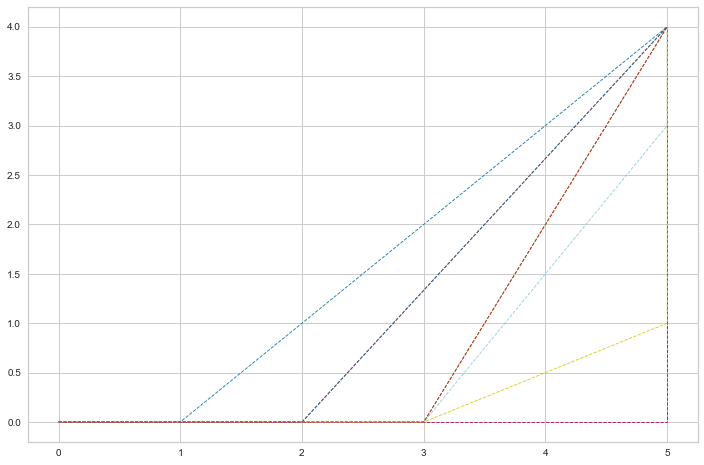

In [24]:
for k in range(len(retained_path)):
    plt.plot([x[0] for x in list(retained_path.keys())[k]], [x[1] for x in list(retained_path.keys())[k]], 
             alpha=0.9, ls='--', linewidth=0.9)
plt.show()

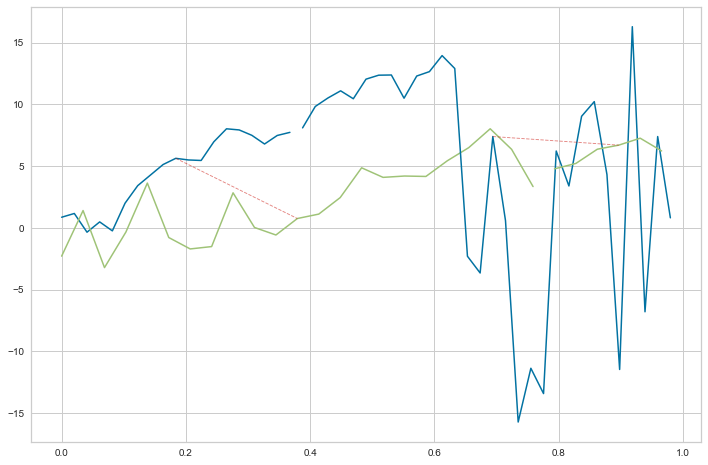

In [442]:
for node1, node2 in zip(l_p_opt[:-1], l_p_opt[1:]):
    
    p1_x = longer_path.T[0][node1[0]:node2[0]]
    p1_y = longer_path.T[1][node1[0]:node2[0]]
    s1 = int((node1[0]+node2[0])/2)
    if s1 < node2[0]:
        mid_1 = s1
    
    p2_x = shorter_path.T[0][node1[1]:node2[1]]
    p2_y = shorter_path.T[1][node1[1]:node2[1]]
    s2 = int((node1[1]+node2[1])/2)
    if s2 < node2[1]:
        mid_2 = s2
    
    plt.plot(p1_x, p1_y, linewidth=1.5, ls='-', c='b')
    plt.plot(p2_x, p2_y, linewidth=1.5, ls='-', c='g')
    plt.plot([longer_path.T[0][mid_1], shorter_path.T[0][mid_2]], 
             [longer_path.T[1][mid_1], shorter_path.T[1][mid_2]], 
             'r--', linewidth=0.9, alpha=0.5)
    
plt.show()

### unit tests

In [813]:
# unit test 1: check that brute force and recursion agree
p_var = 1
depth = 2
norm = 'l1'
width = 2
long_dim = 3
short_dim = 2
longer_path = np.random.rand(long_dim, width)
shorter_path = np.random.rand(short_dim, width)
G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
p_v, l_p = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)
p_brute, opt_path_brut, all_p_brute = brute_force_warped_pvariation(longer_path, shorter_path, 
                                                                    [k for k in ordered_lattice_paths if len(k)>=long_dim], 
                                                                    p_var, depth, norm)
key_list = list(all_p_brute.keys())
to_test = np.random.randint(len(key_list))
np.abs(all_p_brute[key_list[to_test]] - p_variations[key_list[to_test]]) < 5e-1

True

In [814]:
# unit test 2: check that if one of the 2 paths is null then the calc resumes to the p-variation of the one rough path
p_var = 1
depth = 2
norm = 'l1'
width = 2
long_dim = 5
short_dim = 1
longer_path = np.random.rand(long_dim, width)
shorter_path = np.random.rand(short_dim, width)
G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
p_v, l_p = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)
np.abs(list(p_variations.values())[-1] - p_variation_path(p_var, longer_path, depth, norm)) < 1e-10

True

In [815]:
# unit test 3: check that the result is invariant to very simple re-parametrization
p_var = 1
depth = 2
norm = 'l1'
width = 2
long_dim = 5
short_dim = 3

longer_path = np.random.rand(long_dim, width)
shorter_path = np.random.rand(short_dim, width)
G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
pv1, _ = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)

longer_path = np.array([longer_path[0]] + longer_path.tolist())
G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
pv2, _ = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)

np.abs(pv1 - pv2) < 1e-10

True

In [816]:
# unit test 4: triangular inequality
p_var = 1
depth = 2
norm = 'l1'
width = 2

long_dim = 5
mid_dim = 4
short_dim = 3

longer_path = np.random.rand(long_dim, width)
mid_path = np.random.rand(mid_dim, width)
shorter_path = np.random.rand(short_dim, width)

G1, _ = generate_network(long_dim, mid_dim)
G2, _ = generate_network(long_dim=mid_dim, short_dim=short_dim)
G3, _ = generate_network(long_dim, short_dim)

ordered_lattice_paths1 = prepare_lattice_paths(G1, long_dim, mid_dim)
ordered_lattice_paths2 = prepare_lattice_paths(G2, mid_dim, short_dim)
ordered_lattice_paths3 = prepare_lattice_paths(G3, long_dim, short_dim)

initialization_value1 = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(mid_path, depth), norm)
initialization_value2 = sig_norm(tosig.stream2sig(mid_path, depth), tosig.stream2sig(shorter_path, depth), norm)
initialization_value3 = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)

signature_pairwise_distances = {((0,0), (long_dim-1, mid_dim-1)) : initialization_value1}
p_variations = {((0,0), (long_dim-1, mid_dim-1)) : initialization_value1}
global_minimum = {'GM':initialization_value1}
pv1, _ = final_p_variation(ordered_lattice_paths1, longer_path, mid_path, p_var, depth, norm)

signature_pairwise_distances2 = {((0,0), (mid_dim-1, short_dim-1)) : initialization_value2}
p_variations = {((0,0), (mid_dim-1, short_dim-1)) : initialization_value2}
global_minimum = {'GM':initialization_value2}
pv2, _ = final_p_variation(ordered_lattice_paths2, mid_path, shorter_path, p_var, depth, norm)

signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value3}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value3}
global_minimum = {'GM':initialization_value3}
pv3, _ = final_p_variation(ordered_lattice_paths3, longer_path, shorter_path, p_var, depth, norm)

pv1 + pv2 >= pv3

True

In [817]:
# unit test 5: symmetry
p_var = 1
depth = 2
norm = 'l1'
width = 2
long_dim = 3
short_dim = 2
longer_path = np.random.rand(long_dim, width)
shorter_path = np.random.rand(short_dim, width)

G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
p_v1, _ = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)

G, layout = generate_network(long_dim, short_dim)
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim)
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
global_minimum = {'GM':initialization_value}
p_v2, _ = final_p_variation(ordered_lattice_paths, shorter_path, longer_path, p_var, depth, norm)

np.abs(p_v1 - p_v2) < 1e-16

True

# Rough-Warped KNN

In [121]:
p_var = 2
depth = 2
norm = 'l1'

transform_flag = None

xx_train, yy_train = random_subsample(size=2, replace=False, transform_flag=transform_flag)
xx_test = which_transform(transform_flag)[2]
yy_test = which_transform(transform_flag)[3]

x = xx_train[4][::2]
y = xx_train[3][::2]

if len(x)<len(y):
    shorter_path = x
    longer_path = y
else:
    shorter_path = y
    longer_path = x
    
long_dim = longer_path.shape[0]
short_dim = shorter_path.shape[0]

#!!!!
# for a faster comparison we should create a large graph, rich enough to contain all sub-graphs 
# corresponsding to all possible combinations of digits

# generate lattice graph
G, layout = generate_network(long_dim, short_dim)

# initialize warpings
ordered_lattice_paths = prepare_lattice_paths(G, long_dim, short_dim, cutoff=3)

# initiaization value
initialization_value = sig_norm(tosig.stream2sig(longer_path, depth), tosig.stream2sig(shorter_path, depth), norm)

# memoization
signature_pairwise_distances = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
p_variations = {((0,0), (long_dim-1, short_dim-1)) : initialization_value}
inf_p_vars_by_warping_steps = {1:initialization_value}

In [122]:
t = time.time()
p_v, l_p = final_p_variation(ordered_lattice_paths, longer_path, shorter_path, p_var, depth, norm)
print('p-val: {:.3f}, time taken: {:.3f} s'.format(p_v, time.time()-t))
print('warping path: {}'.format(l_p))

p-val: 2.992, time taken: 25.756 s
warping path: [(0, 0), (23, 22)]
